# FROG TESTING

heres where all the random testing is gonna go for frog stuff for now.

in the future you will make seperate juypter lab files for different things. but now just seperate diff ideas with a markdown cell


In [1]:
import numpy as np
import cv2 as cv #opencv - for reading in images
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
%matplotlib inline

### Image processing

start by taking the data from the spectrograph and turning it into the standard plots that are the FROG inputs

what functions do we want:

     - read in spectrograph and calibration files, then output the processed trace, and the processed I vs delay and S vs wvl/freq plots
     
         - process meaning any changes to the temporal or spectral spacing to make frog input easier, so making trace matrix NxN, or centering the spectral data on the carrier freq for FFT stuff
     
     - read in spectrograph and calibration files then save processed image as a picture and NxM matrix, and the processed temporal and spectral intensities 

In [36]:
# start with reading in the image
# assuming function will stay in parent folder of all data folders (same as liam)
folder = './First Stage/' 
fname = 'First Stage.png'
# function input: file name (including path)
raw_pic = cv.imread(folder+fname,cv.IMREAD_UNCHANGED) # -1 flag is to leave unchanged
# the orientation of the matrix vs the picture is flipped, does it need to be flipped back??
# confirm that spectrogram is delays(x) and wvl(y) 
# b/c that is opposite convention of trebino's frog, but does make sense in contxt of image


# next step is to 

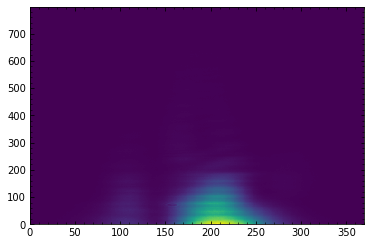

In [34]:
plt.pcolormesh(raw_pic);